In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import speclite.filters as spec

In [2]:
cosmo = FlatLambdaCDM(Om0=0.3, H0=70)

In [3]:
kcorr = pyfits.open("/Users/philipp/Documents/PhD/lum_func_measurement/templates/k_nmf_derived.default.fits")

seds = kcorr[1].data
kcorr_wave = kcorr[11].data

In [4]:
# change seds from erg/s/cm^2/A to uJy
# lambda^2 / c * 1e29
for i in range(5):
    seds[i,:] = seds[i,:] * ((kcorr_wave*kcorr_wave*1e-10)/2.99e8) * 1e29

In [5]:
cat = pyfits.open("/Users/philipp/Documents/PhD/Data/COSMOS2020_Classic_processed.fits")[1].data
eazy_cosmos = pyfits.open("/Users/philipp/Documents/PhD/lum_func_measurement/eazy-out/Cosmos/cosmos.eazypy.data.fits")
coeff = eazy_cosmos[4].data


In [6]:
print(len(cat))
print(len(coeff))

723897
723897


In [7]:
mask = np.where((23.9-2.5*np.log10(cat['UVISTA_Ks_FLUX_APER3'])<25.5)&(cat['photoz']>0))[0]

cat = cat[mask]
coeff = coeff[mask]
print(len(cat))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


441277


In [8]:
filt_name = np.array(['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 
             'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 
             'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 
             'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 
             'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4'])  
filt_lambda = 1e4*np.array([0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,
                            1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,
                            0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,
                            0.8978,0.9063,3.5686,4.5067,5.7788,7.9958])

In [9]:
use_filt = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 28])
filt_name[use_filt]

array(['HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y',
       'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_B'], dtype='<U12')

In [10]:
W21_phot = np.array([cat["{}_FLUX_APER3".format(band)] for band in filt_name[use_filt]]).T
W21_err = np.array([cat["{}_FLUXERR_APER3".format(band)] for band in filt_name[use_filt]]).T

# There are some -99's in this cat, that I think should be NaNs
W21_phot[W21_phot==-99.] = np.nan

# restrict lambda to chosen filters
W21_lam = filt_lambda[use_filt]

In [11]:
ob = 50020
print(cat['photoz'][ob])
print(coeff[ob,:], np.sum(coeff[ob,:]))
# print(coeff[ob,:]*amps, np.sum(coeff['coeffs'][ob,:]*amps))

1.9993
[0.0000000e+00 1.5798374e+17 2.2072759e+20 7.0534339e+19 0.0000000e+00] 2.9141991e+20


In [12]:
sed = np.sum(seds.T*coeff[ob,:], axis=1)
wave_mask = np.where((kcorr_wave*(1+cat['photoz'][ob])>3300)&(kcorr_wave*(1+cat['photoz'][ob])<50000))[0]

In [13]:
a = 1./1.011705685618729e+29 # where is this coming from?h7

In [14]:
plt.rc('font',**{'family':'serif','size':14})
plt.rc('text', usetex=True)

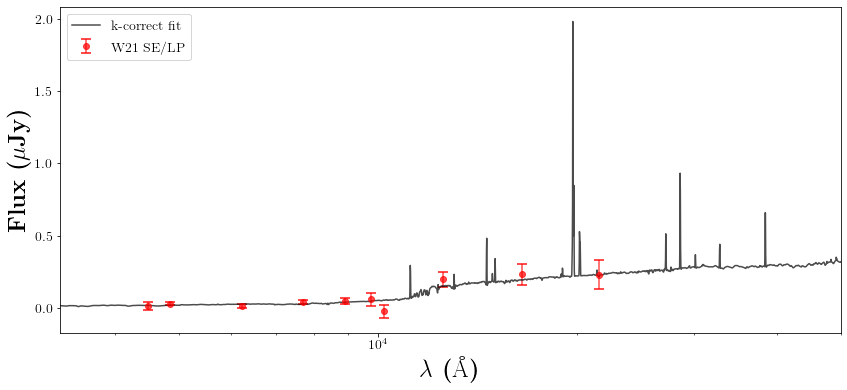

In [15]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(W21_lam, W21_phot[ob,:], yerr=W21_err[ob,:], marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), sed[wave_mask]*a, 'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
ax.legend(fontsize=14, loc=2)
plt.show()

(array([9175]),)
[1577098.5]


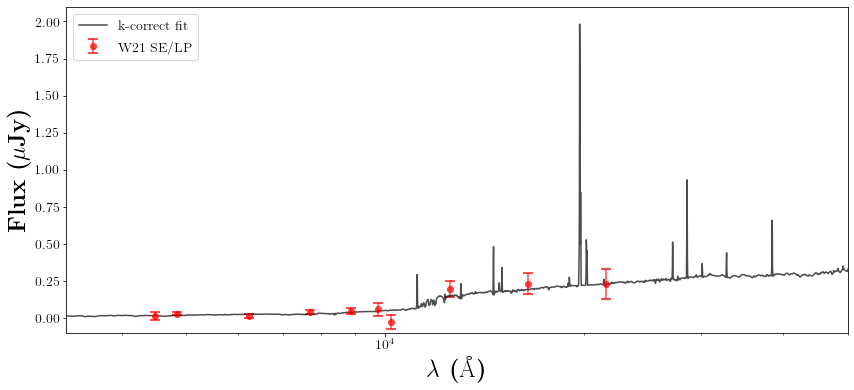

In [16]:
print(np.where(sed*a == max(sed*a)))
print(kcorr_wave[np.where(sed*a == max(sed*a))])
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(W21_lam, W21_phot[ob,:], yerr=W21_err[ob,:], marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave*(1+cat['photoz'][ob]), sed*a, 'k-', alpha=0.7, label='k-correct fit')

ax.set_ylim([-0.1, 2.1])
ax.set_xlim([3300.,50000.])
ax.legend(fontsize=14, loc=2)
plt.show()

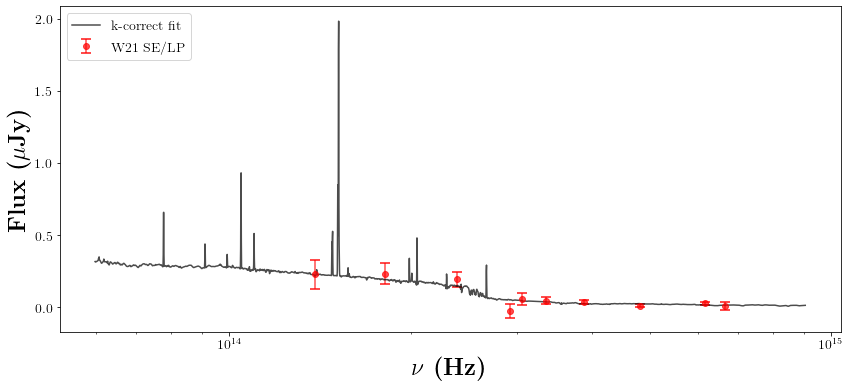

In [17]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\nu$ (Hz)}', fontsize=24)
ax.set_ylabel(r'\textbf{Flux ($\mu$Jy)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(2.99e8 / (W21_lam*10**(-10)), W21_phot[ob,:], yerr=W21_err[ob,:], marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(2.99e8 / (kcorr_wave[wave_mask]*(1+cat['photoz'][ob])*10**(-10)), sed[wave_mask]*a, 'k-', alpha=0.7, label='k-correct fit')

#ax.set_xlim([2.99e8/(3300.**10**(-10)),2.99e8/(50000.*10**(-10))])
ax.legend(fontsize=14, loc=2)
plt.show()

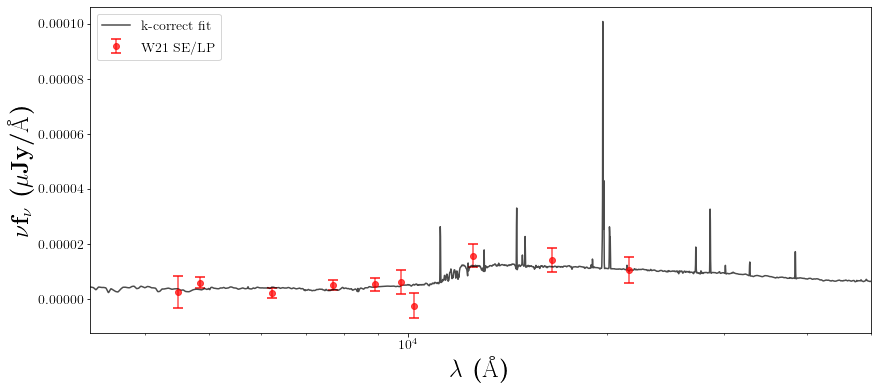

In [18]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{$\lambda$ (${\rm \AA}$)}', fontsize=24)
ax.set_ylabel(r'\textbf{$\nu$f$_{\nu}$ ($\mu$Jy/${\rm \AA}$)}', fontsize=24)
ax.set_xscale('log')

ax.errorbar(W21_lam, W21_phot[ob,:]/W21_lam, yerr=W21_err[ob,:]/W21_lam, marker='o', c='r', 
            label='W21 SE/LP', capthick=2, capsize=5, ls='', alpha=0.7)

ax.plot(kcorr_wave[wave_mask]*(1+cat['photoz'][ob]), 
        sed[wave_mask]*a/(kcorr_wave[wave_mask]*(1+cat['photoz'][ob])), 
        'k-', alpha=0.7, label='k-correct fit')

ax.set_xlim([3300.,50000.])
ax.legend(fontsize=14, loc=2)
plt.show()

### Calculate K-Corrections

In [60]:
def k_correction(sed, wave_observed, redshift, filter_abs, filter_app):
    '''Calculate the k-correction between AB-magnitudes.
    sed: array_like
        Observed flux as a function of observed wavelength.
    wave_observed: array_like
        Observed wavelength in Angstrom.
    redshift: float or array_like
        Redshift of the object.
    filter_abs, filter_app: speclite response object
        The bandpasses of the K-correction
    '''
#     print(sed.shape)
    wave_emitted = (wave_observed.T / (1+redshift)).T
#     print(wave_emitted.shape)
    frequency_emitted = 2.99e8 / (wave_emitted*10**(-10))
    frequency_observed = 2.99e8 / (wave_observed*10**(-10))
#     print("Frequency emitted: ", frequency_emitted.shape)
#     print("Frequency observed: ", frequency_observed.shape)
    
    response_emitted = np.interp(wave_emitted, filter_abs.wavelength, filter_abs.response)
    response_observed = np.interp(wave_observed, filter_app.wavelength, filter_app.response)
    int_sed_observed = np.sum(1./frequency_observed * sed * response_observed, axis=-1)
#     print(np.sum(1./frequency_observed * sed * response_observed, axis=-1).shape)
#     print("Shape int obs.: ", int_sed_observed)
    int_sed_emitted = np.sum(1./frequency_emitted * sed * response_emitted, axis=-1)
#     print("Shape int em.: ", int_sed_emitted)
    
    AB_zero = 3631 * 10**6 # in muJy and frequency space
    norm_observed = np.sum(1./frequency_observed * AB_zero * response_observed)
    norm_emitted = np.sum(1./frequency_emitted * AB_zero * response_emitted)
    
    return -2.5 * np.log10((1+redshift) * int_sed_observed/norm_observed * norm_emitted/int_sed_emitted)
    

In [61]:
i_band = spec.load_filter('hsc2017-i')
B_band = spec.load_filter('bessell-B')

In [62]:
indices = np.random.choice(len(cat), size=2, replace=False)
cat_reduced = cat[indices]
coeff_reduced = coeff[indices,:]

In [63]:
seds_cat = np.zeros((len(cat_reduced), len(kcorr_wave)))
wave = np.zeros((len(cat_reduced), len(kcorr_wave)))
for i in range(len(cat_reduced)):
    seds_cat[i] = np.sum(seds.T*coeff_reduced[i,:], axis=1)*a
    wave[i] = kcorr_wave*(1+cat_reduced['photoz'][i])
    print(k_correction(seds_cat[i], wave[i], cat_reduced['photoz'][i], B_band, i_band))

-0.5602896076208825
-0.4753594453396035


In [64]:
kcorrections = k_correction(seds_cat, wave, cat_reduced['photoz'], B_band, i_band)
print(kcorrections)

[-0.56040225 -0.47524679]


In [65]:
# get seds and wavelenghts broadcasting
seds_cat = np.sum(seds*coeff_reduced[:,:,np.newaxis], axis=1) * a
wave = kcorr_wave*(1+cat_reduced['photoz'][:,np.newaxis])

In [66]:
kcorrections = k_correction(seds_cat, wave, cat_reduced['photoz'], B_band, i_band)

In [67]:
print(cat_reduced['photoz'])
print(kcorrections)

[0.3648 1.6143]
[-0.56040231 -0.47524674]


In [68]:
d = np.array([[1,1,1],[2,2,2]])
print(d.shape)
print(d.sum(axis=0), d.sum(axis=0).shape)
print(d.sum(axis=1), d.sum(axis=1).shape)
print(d.sum(axis=-1), d.sum(axis=-1).shape)
print('#####')
d = np.array([1,1,1])
print(d.sum())
print(d.sum(axis=0))
print(d.sum(axis=-1))

(2, 3)
[3 3 3] (3,)
[3 6] (2,)
[3 6] (2,)
#####
3
3
3


### Get absolute magnitudes for all galaxies

Because of memory reasons I will calculate them in a loop

In [71]:
abs_mag = np.zeros(len(cat))
for i in range(len(cat)):
    seds_cat = np.sum(seds.T*coeff[i,:], axis=1)*a
    wave = kcorr_wave*(1+cat['photoz'][i])
    k_correct = k_correction(seds_cat, wave, cat['photoz'][i], B_band, i_band)
    abs_mag[i] = cat['HSC_i_MAG_APER3'][i] - cosmo.distmod(cat['photoz'][i]).value - k_correct

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


In [72]:
print(abs_mag)

[-18.23301665 -16.69588853 -17.82818893 ... -22.5080648  -20.47913582
 -20.9368777 ]


In [92]:
len(cat['HSC_i_MAG_APER3'][np.isnan(cat['HSC_i_MAG_APER3'])])

311

In [93]:
len(abs_mag[np.isnan(abs_mag)])

357

In [81]:
mag_hist, bin_edges = np.histogram(abs_mag, bins=100, range=(-28,0))
bin_centers = bin_edges[:-1] + (bin_edges[-1]-bin_edges[0])/(2*len(bin_edges))

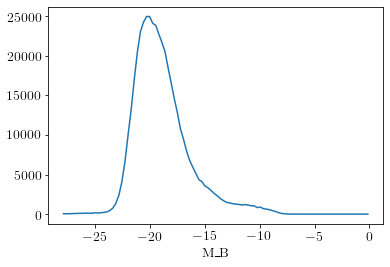

In [82]:
plt.plot(bin_centers, mag_hist)
plt.xlabel("M\_B")
plt.show()

In [95]:
type(cat)

astropy.io.fits.fitsrec.FITS_rec

### Save absolute magnitudes into file

In [103]:
from astropy.table import Table, Column

In [106]:
col = Column(abs_mag, name='AbsMag')
t = Table()

In [107]:
t.add_column(col)

In [113]:
print(len(t))
print(len(cat))

441277
441277


In [114]:
t.write("/Users/philipp/Documents/PhD/Data/Cosmos_Classic_absolute_mags.fits", format='fits')